# GitHub repositories analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

## Read the data

In [2]:
files = glob.glob("./data/**/*.csv", recursive=True)
print("Encontrados", len(files), "ficheros")

Encontrados 28 ficheros


In [3]:
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [4]:
df["ts"] = pd.to_datetime(df["ts"], format='%Y-%m-%d')

In [5]:
ts_max = df["ts"].unique().max()
today = df[df.ts==ts_max]
head_total = 5 if today.ts.count()>5 else today.ts.count()

In [6]:
columns=["name","views_total","views_uniques","clones_total"]
today[columns].sort_values(by=["views_total","views_uniques"], ascending=False).head(head_total)

,name,views_total,views_uniques,clones_total
183,kotlin-ktor,23,1,0
185,ml-github,11,1,6
182,istio-wasm-filter-golang,3,2,0
186,mqtt-golang-influxdb,2,2,0
177,b0rr3g0-blog,2,1,0


In [7]:
repos = df.name.unique().tolist()

In [8]:
dict_df_repos = dict()
for repo_name in repos:
    dict_df_repos[repo_name] = df[df.name==repo_name]

## Data analysis

In [9]:
df_grouped = df.groupby(['name']).agg({"stars_count": ["max"],"clones_uniques": ["sum"],"views_total": ["sum", "max"]})

### Views

In [10]:
views_best_quantile = 0.75
views_worst_quantile = 0.25
best_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_best_quantile)
worst_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_worst_quantile)
print("Best views over:", best_views_percentile)
print("Worst views under:", worst_views_percentile)

Best views over: 18.5
Worst views under: 0.0


In [11]:
views=df_grouped[('views_total')]
views_best = views[views['sum'] > best_views_percentile]
views_best.sort_values(by='sum', ascending=False)

,sum,max
name,,
quarkus-kotlin-example,282,85
ocp-monitoring-golang,192,137
kotlin-ktor,164,41
ml-github,121,41
mqtt-golang-influxdb,101,49
golang-rest-api-cassandra,76,27
kustomize-vs-helm,75,24
golang-k8s-helm-helloworld,70,43
istio-wasm-filter-golang,51,24


#### Best views repositories

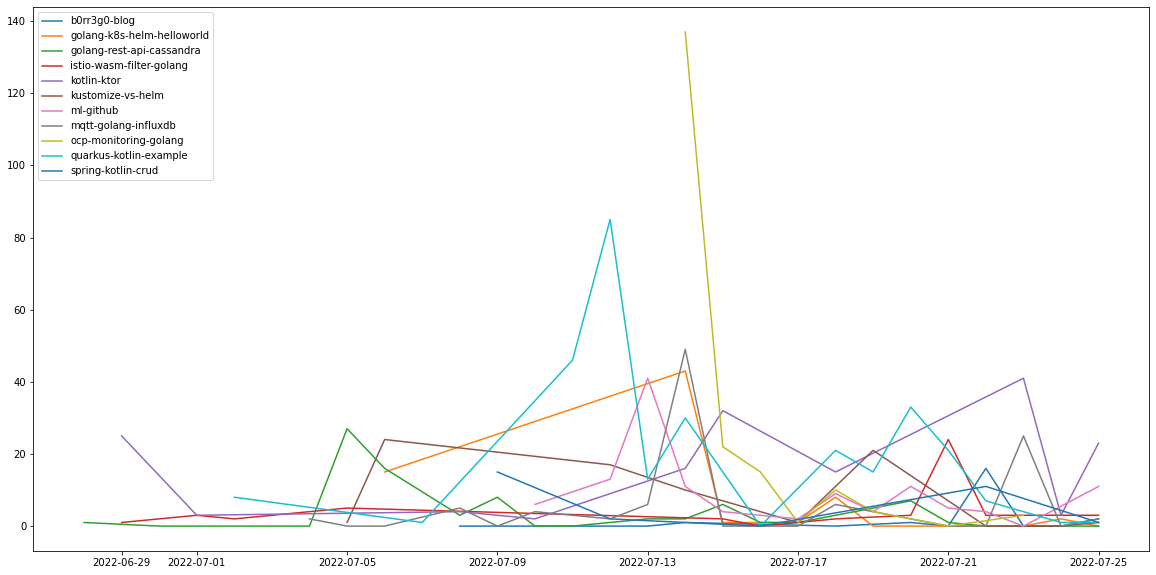

In [12]:
plt.figure(figsize=(20,10))
for repo_name in views_best.index.tolist():
    df_r = dict_df_repos[repo_name].sort_values(by="ts")
    x = df_r.ts
    y = df_r.views_total
    plt.plot(x, y, label=repo_name)
    
plt.legend(loc = "upper left")

#### Sum views total

In [13]:
df_total_views=df.groupby(['ts']).agg({"views_total": ["sum"]}).sort_values(by="ts", ascending=True)

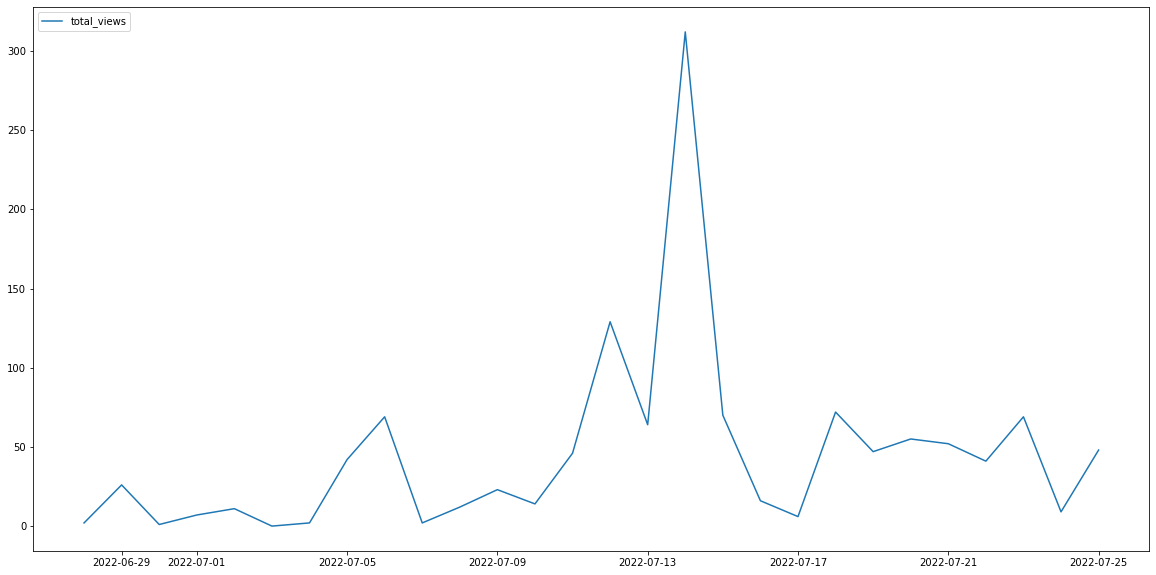

In [14]:
plt.figure(figsize=(20,10))
x = df_total_views.index
y = df_total_views[('views_total', 'sum')]
plt.plot(x, y, label="total_views")
plt.legend(loc = "upper left")

### Clones

In [15]:
# calculate the best 25% repositories
best_clones_quantile = 0.75
worst_clones_quantile = 0.25
best_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(best_clones_quantile)
worst_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(worst_clones_quantile)
print("Best clones over:", best_clones_percentile)
print("Worst clones under:", worst_clones_percentile)

Best clones over: 2.75
Worst clones under: 1.0


In [16]:
clones=df_grouped[('clones_uniques')]
clones_best = clones[clones['sum'] > best_clones_percentile]
clones_best.sort_values(by='sum', ascending=False)

,sum
name,
golang-rest-api-cassandra,569
ta,341
iot-devices-crud,257
mqtt-golang-influxdb,210
ml-github,50
b0rr3g0-blog,14
ocp-monitoring-golang,13
golang-k8s-helm-helloworld,5
pelorus-workshop,5


# Stars

In [17]:
# calculate the best 50% repositories
best_stars_quantile = 0.75
worst_stars_quantile = 0.25
best_stars_percentile = df_grouped[('stars_count', 'max')].quantile(best_stars_quantile)
worst_stars_percentile = df_grouped[('stars_count', 'max')].quantile(worst_stars_quantile)
print("Best stars over:", best_stars_percentile)
print("Worst stars under:", worst_stars_percentile)

Best stars over: 1.0
Worst stars under: 0.0


In [18]:
stars=df_grouped[('stars_count')]
stars_best = stars[stars['max'] > best_stars_percentile]
stars_best.sort_values(by=['max'], ascending=False)

,max
name,
mqtt-golang-influxdb,10
spring-kotlin-crud,6
kotlin-ktor,5
kops-aws,4
kustomize-vs-helm,3
ta,3
golang-k8s-helm-helloworld,2
golang-rest-api-cassandra,2
quarkus-kotlin-example,2


# Red zone

In [19]:
df_red_zone = df_grouped[df_grouped[('stars_count', 'max')] <= worst_stars_percentile]
df_red_zone = df_red_zone[df_red_zone[('clones_uniques', 'sum')] <= worst_clones_percentile]
df_red_zone = df_red_zone[df_red_zone[('views_total', 'sum')] <= worst_views_percentile]
df_red_zone.index.values.tolist()

['REST-Services-MySQL',
 'amq-streams-workshop',
 'influxdb-telegraf-grafana',
 'iot-esp8266-dht11',
 'kubernetes-golang-operator',
 'kubernetes-helm-operator',
 'ms-config-server',
 'spring-cloud-config',
 'spring-cloud-dataflow',
 'spring-cloud-eureka']